In [7]:
import warnings
import os
import glob
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
from spca_utils import compute_spca
from clustering_utils import perform_gmm_clustering
from eigen_utils import compute_sorted_eigen
from projection_utils import project_components
from adjacency_matrix_delaunay import compute_delaunay_matrices
from hungarian_algorithm import apply_hungarian_algorithm
import tracemalloc
import time
warnings.filterwarnings("ignore")

In [2]:
# Set up environment variables for R
os.environ['R_HOME'] = "C:/Users/assali.i/AppData/Roaming/Microsoft/Windows/Start Menu/Programs/R/R 4.3.3"
os.environ['R_USER'] = "C:/Users/assali.i/AppData/Local/anaconda3/envs/ines_env_tf_gpu/Lib/site-packages/rpy2"

# Define folder path for .h5ad files
folder_path = "C:/Users/assali.i/Desktop/Aout/Benchmark_Dataset/10xvisium"

# Get a list of all .h5ad files in the folder
file_paths = glob.glob(os.path.join(folder_path, "*.h5ad"))

# Example: Read a specific .h5ad file (e.g., "151673.h5ad")
file_to_read = "151673.h5ad"
adata = ad.read_h5ad(os.path.join(folder_path, file_to_read))

# Display the AnnData object
print(adata)
# Convert the count matrix to a dense format (DataFrame)
X_dense = adata.X.toarray()

# Preprocessing: Normalize and log transform the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Display the number of unique labels in 'ground_truth'
num_labels = adata.obs['ground_truth'].nunique()
print(f"Number of unique labels in 'ground_truth' (excluding NaN) for {file_to_read}: {num_labels}")

# Start memory and time tracking
tracemalloc.start()  
start_time = time.time()

# Compute Delaunay triangulation to obtain distances and connectivity
dist_matrix, connectivity_matrix = compute_delaunay_matrices(adata)

# Convert the connectivity matrix to a sparse CSR matrix
connectivity_matrix = csr_matrix(connectivity_matrix)

# Add the computed distances and connectivities to the AnnData object
adata.obsp['distances'] = dist_matrix
adata.obsp['connectivities'] = connectivity_matrix

# Perform SPCA on the standardized connectivity matrix
A = compute_spca(adata)

# Compute and sort eigenvalues and eigenvectors
sorted_eigenvalues, sorted_eigenvectors = compute_sorted_eigen(A, num_eigenvalues=10)

# Project data onto different numbers of eigenvectors (e.g., 10)
projection_dfs = {
    num: project_components(X_dense, np.real(sorted_eigenvectors), num)
    for num in [10]
}

# Perform GMM clustering on the projected data
gmm_clusters = {
    f'sPCA_{num}': perform_gmm_clustering(projection_df, num_labels, random_state=42)
    for num, projection_df in projection_dfs.items()
}

# Stop memory tracking and compute elapsed time
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

# Record elapsed time and memory usage
during_time = time.time() - start_time
memory = peak / 1024 / 1024  # Convert to MB

# Add GMM cluster labels to the AnnData object
for key, labels in gmm_clusters.items():
    adata.obs[f'GMM_clusters_{key}'] = labels
    adata.obs[f'GMM_clusters_{key}_Categorical'] = pd.Categorical(labels)

# Create a new AnnData object for storing the results
new_data = adata.copy()

# Store the memory and time information in the `uns` attribute
new_data.uns['time'] = during_time
new_data.uns['memory'] = memory

# Save the result to a new file
result_path = 'C:/Users/assali.i/Desktop/Done data/Spca'

new_data.write(f'{result_path}/spca_151673_new.h5ad')
print(during_time)

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region', 'ground_truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
Number of unique labels in 'ground_truth' (excluding NaN) for 151673.h5ad: 7
37.322951316833496


# Visualization 

In [3]:
# Apply Hungarian algorithm for label matching and update AnnData object
gt_key = 'Region'  # Ground truth labels column name
for key in gmm_clusters.keys():
    # Drop NaNs before applying the Hungarian algorithm
    cluster_labels = adata.obs[f'GMM_clusters_{key}_Categorical']
    valid_idx = ~adata.obs[gt_key].isna() & ~cluster_labels.isna()
    valid_gt_result = adata.obs[gt_key][valid_idx]
    valid_cluster_labels = cluster_labels[valid_idx]
    
    # Apply the Hungarian algorithm for label matching
    mapped_labels = apply_hungarian_algorithm(valid_gt_result, valid_cluster_labels)
    
    # Create a full-length array with NaNs in the original NaN positions
    full_mapped_labels = np.full(len(adata), np.nan, dtype=object)
    full_mapped_labels[valid_idx] = mapped_labels
    
    # Update the AnnData object with the matched cluster labels
    adata.obs[f'GMM_clusters_{key}_Hungarian'] = pd.Categorical(full_mapped_labels, categories=adata.obs[gt_key].cat.categories)

In [4]:
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region', 'ground_truth', 'GMM_clusters_sPCA_10', 'GMM_clusters_sPCA_10_Categorical', 'GMM_clusters_sPCA_10_Hungarian'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'
    obsp: 'distances', 'connectivities'

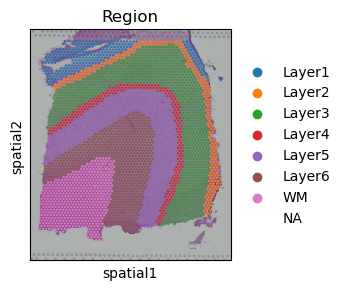

In [5]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["Region"], spot_size=100)

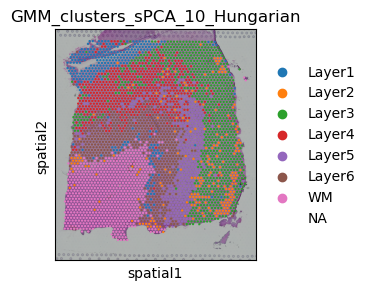

In [6]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["GMM_clusters_sPCA_10_Hungarian"], spot_size=100)